In [ ]:
#Import libraries
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries


In [16]:

# === Load model ===
model = tf.keras.models.load_model("trained_model/ResNet50.keras")  

In [17]:
# === Settings ===
img_size = (224, 224)
base_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data"

# === Collect all image paths and labels ===
image_paths, labels = [], []
for label_folder in ["0", "1"]:  # 0 = Benign, 1 = Malignant
    folder = os.path.join(base_dir, label_folder)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder, fname))
            labels.append(int(label_folder))


# LIME Explanation

C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data\0\6e1e7497dc9c4de99956e5e987db8ef8_1-246_aug3935.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

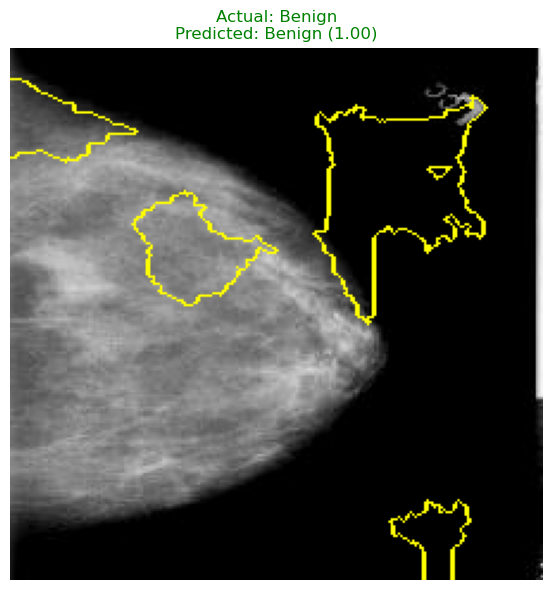

In [18]:
# # === Randomly choose one image ===
idx = random.randint(0, len(image_paths) - 1)
img_path = image_paths[idx]
true_label = labels[idx]

print(img_path)


# === Load image ===
img = image.load_img(img_path, target_size=img_size)
img_np = np.array(img).astype(np.uint8)


# === Define prediction function for LIME ===
def predict_fn(images):
    processed = []
    for im in images:
        im_resized = tf.image.resize(im, img_size)
        arr = tf.keras.applications.resnet50.preprocess_input(np.array(im_resized))
        processed.append(arr)
    processed = np.stack(processed, axis=0)
    preds = model.predict(processed)
    return np.hstack([(1 - preds), preds])  # For binary classification

# === Explain using LIME ===
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_np, 
    classifier_fn=predict_fn, 
    top_labels=2, 
    hide_color=0, 
    num_samples=1000
)

# === Get prediction ===
input_tensor = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(img_np, axis=0).astype(np.float32))
pred_prob = model.predict(input_tensor, verbose=0)[0][0]
pred_class = 1 if pred_prob < 0.5 else 0  # Because 0 = Benign, 1 = Malignant

if pred_class not in explanation.local_exp:
    label_to_explain = explanation.top_labels[0]
else:
    label_to_explain = pred_class

temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    num_features=5,
    hide_rest=False
)
lime_image_overlay = mark_boundaries(temp / 255.0, mask)

actual = "Malignant" if true_label == 1 else "Benign"
predicted = "Malignant" if pred_class == 1 else "Benign"
confidence = f"{pred_prob:.2f}"
title_color = "green" if pred_class == true_label else "red"

# === Show plot ===
plt.figure(figsize=(6, 6))
plt.imshow(lime_image_overlay)
plt.title(f"Actual: {actual}\nPredicted: {predicted} ({confidence})", color=title_color)
plt.axis('off')
plt.tight_layout()
plt.show()


# Calculate Fidelity Score

In [ ]:
# === Configuration ===
data_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data"
img_size = (224, 224)

# === Prediction function for LIME ===
def predict_fn(images):
    images = tf.keras.applications.resnet50.preprocess_input(np.array(images))
    return model.predict(images, verbose=0)

# === Fidelity Score Helper ===
def calculate_fidelity_lime(img_array, explanation, model, prob_original):
    mask = explanation > 0  # Keep superpixels LIME marked as positive
    mask = mask.astype(np.float32)

    masked_img = img_array.copy()
    masked_img[:, :, 0] *= (1 - mask)
    masked_img[:, :, 1] *= (1 - mask)
    masked_img[:, :, 2] *= (1 - mask)

    input_masked = tf.keras.applications.resnet50.preprocess_input(masked_img.copy())
    input_masked = np.expand_dims(input_masked, axis=0)

    prob_masked = model.predict(input_masked, verbose=0)[0][0]
    return prob_original - prob_masked

# === Get all image paths ===
image_paths = [
    os.path.join(root, f)
    for root, _, files in os.walk(data_dir)
    for f in files
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# === Randomly select 50 ===
sample_paths = random.sample(image_paths, min(50, len(image_paths)))

# === LIME Explainer ===
explainer = lime_image.LimeImageExplainer()

fidelity_scores = []

for img_path in sample_paths:
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0  # LIME works better with [0,1] images

    # Original probability
    input_array = tf.keras.applications.resnet50.preprocess_input(img_array.copy() * 255.0)
    input_array = np.expand_dims(input_array, axis=0)
    prob_original = model.predict(input_array, verbose=0)[0][0]

    # LIME explanation
    explanation = explainer.explain_instance(
        img_array.astype(np.double),
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # Fidelity score
    score = calculate_fidelity_lime(img_array * 255.0, mask, model, prob_original)
    fidelity_scores.append(score)

# === Average fidelity score ===
avg_fidelity = np.mean(fidelity_scores)
print(f"Average LIME Fidelity Score over {len(sample_paths)} samples: {avg_fidelity:.4f}")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

📊 Average LIME Fidelity Score over 50 samples: 0.0178


# Calculate IOU Score

In [ ]:
calc_train = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

# Replace the path for cropped_images to the correct directory.
correct_dir = r"C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg"
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0])

# Replace the path for full_mammogram images to the correct directory.
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0]) 

# Replace the path for roi_mask images to the correct directory.
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0])


def get_image_file_name(data, new_dict):
    for dicom in data:
        key = dicom.split('/')[12]
        new_dict[key] = dicom
    print(f"the length of dataset : {len(new_dict.keys())}")

cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

def fix_image_path(data):
    for indx, image in enumerate(data.values):
        img_name = image[11].split('/')[2]

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
        
        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 11] = None

        img_name = image[13].split('/')[2]
        if img_name in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[img_name]

        else:
            data.iloc[indx, 13] = None

fix_image_path(mass_test)

mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
mass_test.head(5)


Cropped Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg

Full mammo Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg

ROI Mask Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg
the length of dataset : 571
the length of dataset : 300
the length of dataset : 582


patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality_type mass_shape   mass_margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

  image_file_path                            cropped_image_file_path  \
0            None  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1            None  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....   
2            None  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
3            None  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....   
4            None  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....   

  ROI_mask_file_path  
0               None  
1               None  
2               None  
3               None  
4               None

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries

# ===== CONFIG =====
IMG_SIZE = 224
model_path = "pretrained_model/ResNet50.keras"
model = tf.keras.models.load_model(model_path)

# ===== PREDICT FUNCTION FOR LIME =====
def f(images):
    # images: list of images (H, W, 3), float in [0, 255]
    images = np.array([tf.keras.applications.resnet50.preprocess_input(img.copy()) for img in images])
    return model.predict(images)

# ===== LIME EXPLAINER =====
explainer = lime_image.LimeImageExplainer()

def get_lime_mask(img_array, class_index=None, top_frac=0.2):

    explanation = explainer.explain_instance(
        img_array.astype(np.uint8), 
        classifier_fn=f, 
        top_labels=2, 
        hide_color=0, 
        num_samples=1000
    )
    
    if class_index is None:
        class_index = explanation.top_labels[0]
    
    temp, mask = explanation.get_image_and_mask(
        class_index,
        positive_only=True,
        num_features=int(top_frac * explanation.segments.max()),  # top fraction of superpixels
        hide_rest=False
    )
    
    # mask: boolean array, shape same as img
    return mask.astype(np.uint8)

# ===== IOU CALCULATION =====
def calc_iou(pred_mask, roi_mask):
    pred_mask = pred_mask.astype(bool)
    roi_mask = roi_mask.astype(bool)
    intersection = np.logical_and(pred_mask, roi_mask).sum()
    union = np.logical_or(pred_mask, roi_mask).sum()
    return intersection / (union + 1e-8)

ious = []
for idx, row in mass_test.iterrows():
    if len(ious) >= 50:  
        break
    img_path = row['image_file_path']
    roi_path = row['ROI_mask_file_path']

    img_array = cv2.imread(img_path)
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

    roi_mask = cv2.imread(roi_path, cv2.IMREAD_GRAYSCALE)
    roi_mask = cv2.resize(roi_mask, (IMG_SIZE, IMG_SIZE))
    roi_mask = (roi_mask > 127).astype(np.uint8)

    lime_mask = get_lime_mask(img_array)
    iou = calc_iou(lime_mask, roi_mask)
    print(iou)
    ious.append(iou)

        

print("Average IOU (LIME):", np.mean(ious))


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step  

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/ste

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
print("Average IOU (LIME):", np.mean(ious))


Average IOU (LIME): 0.02601271203737188


Selected image: C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images\1\8a852f3e0c1f478ca454d47769a42763_1-242_aug802.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

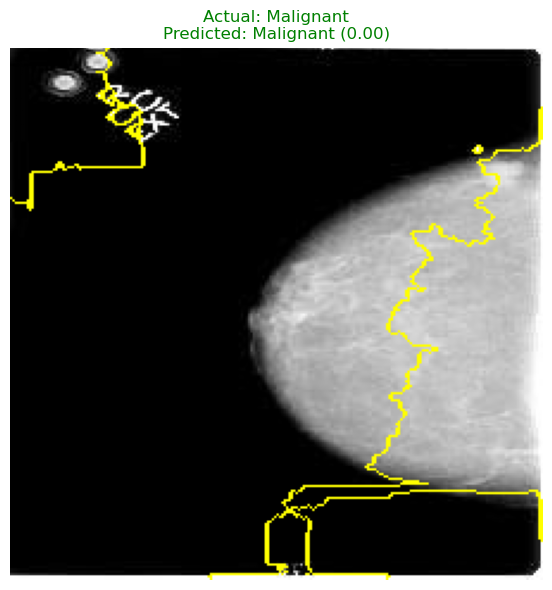

In [ ]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from lime import lime_image
from skimage.segmentation import mark_boundaries

# === Load model ===
model_path = "ResNet50.keras"  # Change to your model file
model = load_model(model_path)
img_size = (224, 224)

# === Collect images & labels ===
base_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images"
image_paths, labels = [], []
for label_folder in ["0", "1"]:
    folder = os.path.join(base_dir, label_folder)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder, fname))
            labels.append(int(label_folder))

# === Randomly choose one image ===
idx = random.randint(0, len(image_paths) - 1)
img_path = image_paths[idx]
true_label = labels[idx]
print(f"Selected image: {img_path}")

# === Load image ===
img = image.load_img(img_path, target_size=img_size)
img_np = np.array(img).astype(np.uint8)

# === Define prediction function for LIME ===
def predict_fn(images):
    processed = []
    for im in images:
        im_resized = tf.image.resize(im, img_size)
        arr = tf.keras.applications.resnet50.preprocess_input(np.array(im_resized))
        processed.append(arr)
    processed = np.stack(processed, axis=0)
    preds = model.predict(processed)
    return np.hstack([(1 - preds), preds])  # For binary classification

# === Time measurement start ===
start_time = time.time()

# === Explain using LIME ===
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_np,
    classifier_fn=predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# === Prediction ===
input_tensor = tf.keras.applications.resnet50.preprocess_input(
    np.expand_dims(img_np, axis=0).astype(np.float32)
)
pred_prob = model.predict(input_tensor, verbose=0)[0][0]
pred_class = 1 if pred_prob < 0.5 else 0  # 0 = Benign, 1 = Malignant

if pred_class not in explanation.local_exp:
    label_to_explain = explanation.top_labels[0]
else:
    label_to_explain = pred_class

# === Extract LIME mask ===
temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    num_features=5,
    hide_rest=False
)
lime_image_overlay = mark_boundaries(temp / 255.0, mask)

# === Time measurement end ===
end_time = time.time()
time_taken = end_time - start_time
print(f"✅ LIME explanation took {time_taken:.3f} seconds")

# === Display ===
actual = "Malignant" if true_label == 1 else "Benign"
predicted = "Malignant" if pred_class == 1 else "Benign"
confidence = f"{pred_prob:.2f}"
title_color = "green" if pred_class == true_label else "red"

plt.figure(figsize=(6, 6))
plt.imshow(lime_image_overlay)
plt.title(f"Actual: {actual}\nPredicted: {predicted} ({confidence})", color=title_color)
plt.axis('off')
plt.tight_layout()
plt.show()
